# ASI assessed exercise 2018/2019
Amyn KASSARA

## Initialization code

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
from pylab import meshgrid
from matplotlib import cm 
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix, lil_matrix
from time import time
from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal


## Exercises  

 <b>Q1. Download and import the Santander dataset. The labels of the test data are not publicly available,so create your own test set by randomly choosing half of the instances in the original training set.</b>



<div class='alert alert-success'>To import the Santander Dataset we are going to use the built-in function pandas.read_csv that reads a comma-separated values (csv) file into DataFrame.</div>

In [3]:
# Read the .csv file:
transactionDF = pd.read_csv('train.csv', error_bad_lines=False)
# Choose a sample from the dataframe:
Train, Test= train_test_split(transactionDF, random_state=42, test_size=.5)

In [4]:
Train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
20237,train_20237,0,11.4978,-3.0777,11.9565,8.8948,11.2996,-10.4822,3.8270,11.4380,...,-6.0965,3.9164,-0.4457,-0.9721,21.6714,1.5506,6.3634,8.1350,21.6712,-8.5367
198821,train_198821,0,6.7885,0.7269,5.8945,5.4038,9.9259,-2.9944,5.4108,16.3829,...,6.1964,11.6020,3.5603,0.6766,20.0554,-1.5801,5.3351,8.6182,9.6734,-13.4286
188009,train_188009,0,8.6802,3.5310,7.9625,7.6073,11.0424,5.7768,4.3228,20.5002,...,7.9154,7.6972,1.6893,4.8253,17.6450,0.9720,-1.3828,7.3101,13.2607,-9.4329
12214,train_12214,0,13.1322,-0.5355,8.9295,9.2934,11.0048,-1.6971,5.3749,14.7257,...,8.5705,8.4554,1.4635,1.0137,14.6109,1.8852,8.9966,8.0651,19.3677,-14.6202
133939,train_133939,0,10.8787,-0.6815,5.0000,5.9295,9.3202,-3.5659,3.5086,18.0152,...,6.2816,7.1930,1.7058,-2.6972,21.1006,0.9372,-4.3809,8.9797,20.3274,-19.3787


 <b>Q2. Comment on the distribution of class labels and the dimensionality of the input and how these may
affect the analysis.</b>

<div class='alert alert-success'>The task of this exercice is to predict the value of target, let's identify the distribution of the values for this label.</div>

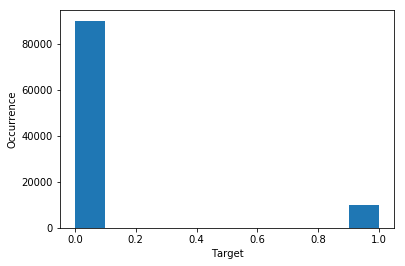

In [5]:
#Target histogram of training data
plt.hist(Train.target)
plt.xlabel('Target')
plt.ylabel('Occurrence')
plt.show()

In [6]:
Train['target'].value_counts()

0    90040
1     9960
Name: target, dtype: int64

In [7]:
print("Percentage of zeros in training data",100*90040/(9960+90040))

Percentage of zeros in training data 90.04


<div class='alert alert-success'>The previous figure shows the label distribution in training set is extremely unbalanced, as we have way more zeros (90040) than ones (9960).  The problem with this kind of unbalanced distribution is that is could clead to the Accuracy paradox: Even a very simple model, that always gives 0 as output, could be extremely accurate. Therefore, evaluating the quality of our model could be problematic.</div>

<div class='alert alert-success'> The Input dimensionality is the total number of columns mines two, as there is one output and one attribute containing the ID_code.</div>

In [8]:
#Input Dimensionality
print("Input Dimensionality is", len(Train.columns)-2)
#Number of data points in training set
print("Number of Data points in training set:", len(Train))

Input Dimensionality is 200
Number of Data points in training set: 100000


<div class='alert alert-success'>Each input will be represented as a vector of 201 elements.
We have 100000 samples for training, and 100000 samples for testing.
As a general rule of thumb, size of training dataset should be at-least about 10x it's dimension and should be independent of the model used. Thus this empirical "rule" is respected .</div>

### Bayesian Linear Regression

 <b>Q3.a. Implement Bayesian linear regression (you should already have an
implementation from the lab sessions).</b>

In [9]:
class BayesianLinearRegression(object):
    #The first method serves to initiate a BayesianLinearRegression model.
    def __init__(self, n_samples=10):
        self.N_SAMPLES = n_samples
        print("Created new instance of Bayesian Linear Regression")

    #The second method serves to fit the input to the corresponding shape.    
    def _X(data):
        data = data.reshape(-1, np.prod(data[0].shape))
        X = np.ones((len(data), 1))
        X = np.hstack((X, data))
        return X
    
    
    #The third BayesianLinearRegression.fit()  serves to train the model,    
    def fit(self, data, labels):
        #We keep track of the training time
        t0 = time()
        
        labels=labels.T   
        X = BayesianLinearRegression._X(data)
        X_T = X.T
        X_T_X = X_T.dot(X)
        shape = X.shape[1]
        self._inv = np.linalg.inv(X_T_X)
        
        #Here we compute the parameters given by the maximum likelihood estimation
        self.w_hat = self._inv.dot(X_T).dot(labels)
        epsilon = labels - X.dot(self.w_hat)
        self.sig_hat = epsilon.T.dot(epsilon)/len(labels)
        
        #S is the covariance matrix of the prior Gaussian distribution, we will analyze this choice later
        S = np.eye(X.shape[1])
        S_inv = np.linalg.inv(S)
        X_T_t = X_T.dot(labels)
        
        #Here we compute the parameters of the posterior distribution
        self.sig_post = np.linalg.inv(X_T_X/self.sig_hat + S_inv) 
        self.mu_post = self.sig_post.dot(X_T_t)/self.sig_hat
        t1 = time()
        print("Built model in {:.2f} seconds".format(t1-t0))
        return
    
     # bayesian linear regression
    def predict_bayes(self, data):
        t0 = time()
        X = BayesianLinearRegression._X(data)
        
        # Compute N_SAMPLES predictions and then average
        t_pred = np.zeros((self.N_SAMPLES, len(X)))
        for i in np.arange(self.N_SAMPLES):
            w_sample = np.random.multivariate_normal(self.mu_post.T.ravel(), self.sig_post ).T
            t_pred[i] = X.dot(w_sample).reshape(-1)
        t1 = time()
        print("Classification time [bayesian linear regression] {:.2f} seconds".format(t1-t0))
        return np.mean(t_pred, axis=0)
    
    def validate(self, correct, raw):
        
        mse = mean_squared_error(correct, raw)
        
        return mse

 <b>Q3.b.Discuss how can you select the (hyper-)parameters for the Gaussian prior</b> 

<div class='alert alert-success'>The parameters of the Gaussian prior are its mean and variance. In our implementation, we set the mean to zero and the variance to the identity matrix.Since we have a lot of data, the choice of the prior won't have a great impact. However  we can explain this choice with the following points:

1) We set the mean of the prior distribution to zero as our data is difficult ot interpret. The prior indicates our prior belief in the variables, here we don't know anything about the variables, by using a zero mean prior we preserve the potential symetrie of the model and we let the data speak.

2) For the covariance matrix, we choose a simple identity matrix for the same reason. We prefer to use a simple model that is symetric, in order not to import a potenial asymetrie in the variables.
<div>

 <b>Q3.c.Write code that calculates the N-th order polynomial transformation of the
input data. For simplicity, do not consider polynomials of more than one variable
(such as x2y), but raise each input variable to the power of N individually.
Consider N=1, 2, 3, and 6.</b> 

In [10]:
#Here we increase the dimension of the input data X by adding simple polynomial transformations of order 2,3 
#and 6
def Poly_transform(X,N):
    X_new = np.column_stack((X, np.power(X,N)))
    return X_new
            

 <b>Q3.d.Describe any additional pre-processing that you suggest for this data</b> 

<div class='alert alert-success'>

1) The first preprocessing step that we could thing of is the normalization of the data. Normalization is the process of scaling individual samples to have unit norm. This process can be useful when we plan to use a quadratic form such as the dot-product or any other kernel to quantify the similarity of any pair of samples.


<div>

In [11]:
def normalize(X,norm):
    X_normalized = preprocessing.normalize(X, norm)
    return X_normalized

<div class='alert alert-success'>

2) We also can remove the outliers. To remove outliers, we will delete the rows that contain an absurd value in at least one column. By absurd here, we mean a value that has a zscore greater than 3. The intuition behind Z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points. To calculate Z-score we re-scale and center the data and look for data points which are too far from zero. Thus a vector that has a high zcore will be far from zero, and will be considered as an outlier.


<div>

In [12]:
# Firt we create the dataframe of attributes numerical values:
numerical_val = transactionDF.select_dtypes(include=[np.number])
numerical_val= numerical_val.drop(["target"],axis=1)
#Then we only keep rows where there is no attribute which zscore is smaller than 3
n=len(transactionDF)
transactionDF =transactionDF[(np.abs(stats.zscore(numerical_val)) < 3).all(axis=1)]
print("Percentage of lost data points:", 100*(n-len(transactionDF))/n)

Percentage of lost data points: 5.5155


 <b>Q3.e.Treat class labels as continuous and apply regression to the training data.
Also, calculate the posterior variance of the weights</b> 

In [13]:
X_train = Train.drop(["target","ID_code"],axis=1)
T_train = Train["target"]
X_test = Test.drop(["target","ID_code"],axis=1)
T_test = Test["target"]

x_train = lil_matrix(X_train).toarray()
x_train= normalize(x_train,'l2')
x_train_N= Poly_transform(x_train,3) 



t_train = lil_matrix(T_train).toarray()

x_test = lil_matrix(X_test).toarray()
x_test= normalize(x_test,'l2')
x_test_N= Poly_transform(x_test,3) 


model = BayesianLinearRegression()
model.fit(x_train_N, t_train)
predicted_blr = model.predict_bayes(x_test_N)

Created new instance of Bayesian Linear Regression
Built model in 1.61 seconds
Classification time [bayesian linear regression] 0.88 seconds


In [14]:
print("Posterior variance of the weights is", model.sig_post)

Posterior variance of the weights is [[ 3.65683355e-03 -2.91174922e-04  3.16539529e-05 ...  3.10765214e-04
   1.64828862e-03  3.04159418e-03]
 [-2.91174922e-04  2.32550642e-03 -1.11927063e-06 ...  4.20182536e-07
   1.55605971e-05 -3.39761585e-04]
 [ 3.16539529e-05 -1.11927063e-06  1.18236603e-03 ... -1.42755564e-06
   1.58396233e-05  2.70563030e-05]
 ...
 [ 3.10765214e-04  4.20182536e-07 -1.42755564e-06 ...  9.99847347e-01
  -1.51841402e-05 -1.92120686e-05]
 [ 1.64828862e-03  1.55605971e-05  1.58396233e-05 ... -1.51841402e-05
   9.77240946e-01 -5.32000064e-05]
 [ 3.04159418e-03 -3.39761585e-04  2.70563030e-05 ... -1.92120686e-05
  -5.32000064e-05  7.29201504e-01]]


 <b>Q3.f.Suggest a way to discretize predictions and display the confusion matrix on the
test data and report accuracy</b> 

<div class='alert alert-success'>

To discretize the predictions the most intuitive idea  would be to round the result to the closest integer.


<div>

In [15]:

labels =(predicted_blr > 0.5).astype(np.int) 

Bayesian linear regression accuracy: 90.15%


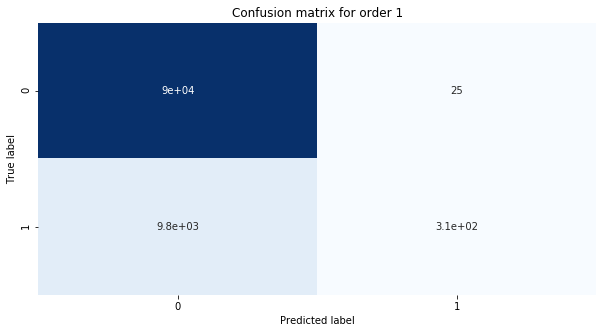

In [16]:
conf = confusion_matrix(T_test, labels)
fig, ax = plt.subplots(figsize=(10, 5))


print("Bayesian linear regression accuracy: {:.2f}%"
      .format(100*accuracy_score(T_test, labels)))


sns.heatmap(conf, cbar=False, cmap='Blues', annot=True, ax=ax)
ax.set_title('Confusion matrix for order 1')
ax.set(xlabel='Predicted label', ylabel='True label')
plt.show()

 <b>Q3.g. Discuss the performance, compare it against a classifier that outputs random
class labels.</b> 

<div class='alert alert-success'>

In our dataset, we have have 90% of the data with a label equal to zero. Thus we create a classifier that predict a zero 90% of the time.

<div>

In [17]:
random_labels= np.random.choice(2,len(T_test),p=[0.9,0.1])
print("Random classification accuracy: {:.2f}%"
      .format(100*accuracy_score(T_test, random_labels)))
print("Constant classification accuracy: {:.2f}%"
      .format(100*accuracy_score(T_test, np.array([0 for k in range(len(T_test))]))))


Random classification accuracy: 82.19%
Constant classification accuracy: 89.86%


<div class='alert alert-success'>

The encountered problem is the Accuracy Paradox that we saw in the first question. A random or even constant classifier is capable of  achieving an accuracy that is very close to the one obtained with a Bayesian Linear Regression. Therefore, the model used in this question doesn't fit to the data. Thus we could doubt of the initial hypothesis of a Bayesian Linear Regression which is that there is a linear relation between the input and the output of the classifier.

<div>

### Logistic Regression

In [18]:
# Read the .csv file:
transactionDF = pd.read_csv('train.csv', error_bad_lines=False)
# Choose a sample from the dataframe:
Train, Test= train_test_split(transactionDF, random_state=42, test_size=.5)

In [19]:
X_train = Train.drop(["target","ID_code"],axis=1)
T_train = Train["target"]
X_test = Test.drop(["target","ID_code"],axis=1)
T_test = Test["target"]

x_train = lil_matrix(X_train).toarray()
x_train= normalize(x_train,'l2')


t_train = np.array(T_train)

x_test = lil_matrix(X_test).toarray()
x_test= normalize(x_test,'l2')

 <b>Q4.a. The goal is to implement a logistic regression classifier that optimizes for the
Maximum a Posteriori (MAP) estimate; assume a Gaussian prior on the parameters.
As a first step, write a function that calculates the gradient of the joint likelihood.</b> 

<div class='alert alert-success'>

The objective function of our optimization algorithm would be the product of the Gaussian prior and the joint likelihood. To make the computation more simple we introduce the logarithm, thus the objective function will be the following:

$$g(w)= log(p(w|\sigma^2))+ \Sigma_{n=1}^N log(p(t_n|x_n,w)) $$

Therefore, if we consider that the prior is a Gaussian and that the model is a logistic regression, the objective function will be:
$$g(w)=-\frac{D}{2}log(2\pi)- \frac{1}{2\sigma}w^{T}w + \Sigma_{n=1}^N -log(1+exp(-t_{n}w^{T}x_n))$$

Where $D$ is the dimensionality of the problem ($D=200$), and $\sigma$ the parameter of the considered covariance diagonal matrix . 

$\frac{D}{2}log(2\pi)$ is a constant parameter. Therefore we can remove it for the optimisation.

The gradient of the objective is:
$$ \nabla g_{w}(w)= \Sigma_{n=1}^N (1-\sigma(t_{n}w^{T}x_{n}))t_{n}x_{n} - \frac{w}{\sigma}$$ 
<div>

In [36]:
D=200
sigma=10
cov_matrix= sigma*np.eye(D+1)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def g(w,X,t):
    G= 0
    for n in range(np.shape(X)[0]):
        G=G - np.log(1+ np.exp(-t[n]*w.dot(X[n,:])))
    
    return G-0.5* w.dot(w.T)/sigma

def nabla_g(w,X,t):
    s = np.dot(t-sigmoid(X.dot(w.T)).T , X)
    return -w/sigma +s
    


 <b>Q4.b. Write a simple gradient descend algorithm that uses the gradients calculated
by the function of previous question to converge to the MAP estimate.</b> 

In [37]:
#This function transforms the input to the corresponding shape to add the bias
def transform_input(x):
    one = np.ones((x.shape[0],1))
    return np.concatenate((one,x) , axis=1)

def gradient_descent( X,t,w, learning_rate , epochs):
    
    c = 1
    w_hat = w
    while c <= epochs:
        gradient = nabla_g(w_hat , X , t)
        w_hat = w_hat + learning_rate*gradient
        c=c+1
        
    return w_hat

In [84]:
X_train= transform_input(x_train)
t_train= np.array(t_train)

#Gradient descent algorithm
learning_rate= 0.0001
n_epochs= 1000
w = np.random.rand(201)
w_hat = gradient_descent(X_train,t_train,w,learning_rate,n_epochs)

 <b>Q4.c. Comment on the convexity of the problem; do you need multiple restarts in order
to obtain a solution sufficiently close to the global optimum?</b> 

<div class='alert alert-success'>

Let's check the convexity of our problem by computing the Hessian of the objective function $g$:

$$g(w)=- \frac{1}{2}w^{T}w + \Sigma_{n=1}^N -log(1+exp(-t_{n}w^{T}x_n))$$

Therefore the Hessian is:

$$\nabla^2 g_{w}(w)= \frac{d^{2}g}{dwdw^T}(w)$$

Then:
$$\nabla^2 g_{w}(w)= -\Sigma_{n=1}^N \sigma(w^{T}x_{n})(1-\sigma(t_{n}w^{T}x_{n}))x_{n}x^{T}_n +I$$

Which in matrix form could be written:
$$\nabla^2 g_{w}(w)= -(XDX^T + I)$$

Where:
$$ D=diag(\sigma(w^{T}x_{n})(1-\sigma(t_{n}w^{T}x_{n})))_{1\leq n \leq N}$$

For every $w$, the matrix $D$ is positive-definite because its eigenvalues are positive as $\sigma$ is a function which values are between $0$ and $1$. Then the matrix $XDX^T$ is also positive definite. $I$ is positive definite.

Therefore $XDX^T + I$ is definite postive. Therefore for every $w$, the Hessian is negative-definite, which means that the objective function is concave. Therefore it admits a unique global maximum and the gradient descent algorithm always converge to this maximum, for any initial $w$. Thus there is no need for multiple restarts.


<div>

 <b>Q4.d. Report the confusion matrix and classification accuracy on the test data.
Discuss logistic regression performance with respect to the performance of
Bayesian linear regression</b> 

In [85]:
X_test= transform_input(x_test)
#Output
t_test = np.array(T_test)

In [86]:
predicted_log= sigmoid(X_test.dot(w_hat.T))
labels = (predicted_log > 0.5).astype(np.int)

Logistic regression accuracy: 90.03%


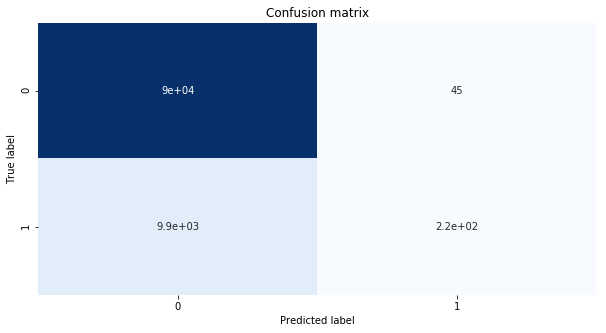

In [87]:
conf = confusion_matrix(t_test, labels)
fig, ax = plt.subplots(figsize=(10, 5))


print("Logistic regression accuracy: {:.2f}%"
      .format(100*accuracy_score(T_test, labels)))


sns.heatmap(conf, cbar=False, cmap='Blues', annot=True, ax=ax)
ax.set_title('Confusion matrix')
ax.set(xlabel='Predicted label', ylabel='True label')
plt.show()

<div class='alert alert-success'>

Therefore, the results using the Logistic Regression don't seem to be accurate as the accuracy of this model is smaller than the previous one, which was a simpler linear model. This could be due to the  gradient descent algorithm that could converge too slowly to a maximum in case of a bad choice of  learning rate or a bad choice of initial point. To decrease the influence of these hyperparameters, we could improve the gradient descent algorithm, by changing the learning rate at each iteration with a backtracking line search for example. 

However, there is no substantial problem in the hyposthesis that we made, in contrary of the Bayesian linear model. The challenge remains in the optimization part, which is purely mathematic, and where we could have better results using more complex algorithms like the Newton method.



<div>

 <b>Q4.e. Laplace approximation is an efficient way to obtain an approximate
posterior for logistic regression. Describe the steps of this approach. What is the form obtained?</b> 

<div class='alert alert-success'>

We can only evaluate the posterior distribution up to a constant: we can evaluate the joint probability $p(t|X,w, \sigma^2)p(w|\sigma^2)$, but not the normalizer $p(t|X, \sigma^2)$. What we could do is to match the shape of the posterior using joint probability, and then the approximation can be used to approximate  $p(t|X, \sigma^2)$. The Laplace approximation sets the mode of the Gaussian approximation to the mode of the posterior distribution, and matches the curvature of the log probability density at that location. 

To do this, we compute first the optimal $w^*$ that maximizes the joint likelihood, like we did in the MAP estimate. Then we compute the Hessian Matrix of the objective function ( which expression was given in Q4.c) to determine the properties of the Gaussian approximation as the Hessian tells us how sharply the distribution is peaked in different directions.

After this, we would have an approximation of the posterior probability, and as we already know the expression of the joint probability, it would be possible  to find an approximation of the normalizer, which would be:
$$p(t|X, \sigma^2)= p(t|X,w, \sigma^2)p(w|\sigma^2)|2\pi H^{-1}|^{\frac{1}{2}} $$

Where $H$ is the Hessian Matrix.

<div>